# Data Import and Cleaning

In [87]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# get rid of SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [41]:
# import data from electronic bins
import os
import glob

columns = ['trans', 'cow', 'bin', 'timein', 'timeout', 'sec', 'kgin', 'kgout', 'kg']
globbed_files = glob.glob('bins0913/*.DAT')
data = []
for dat in globbed_files:
    frame = pd.read_csv(dat, sep=',', header=None, names = columns)
    frame['date'] = os.path.basename(dat) # filename contains date
    frame['date'] = frame['date'].replace({'VW': '', '.DAT': ''}, regex=True) # separate out date from filename
    frame['timein'] = frame['timein'].replace({' ': '0'}, regex=True) # add zero padding to hours
    frame['timeout'] = frame['timeout'].replace({' ': '0'}, regex=True) # add zero padding to hours
    frame['date'] = pd.to_datetime(frame['date']) # convert date and time into correct formats
    frame['timein'] = pd.to_timedelta(frame['timein'])
    frame['timeout'] = pd.to_timedelta(frame['timeout'])
    frame['dt_in'] = frame['date'] + frame['timein']
    frame['dt_out'] = frame['date'] + frame['timeout']
    data.append(frame)

bins = pd.concat(data, ignore_index=True)
bins.head()

,trans,cow,bin,timein,timeout,sec,kgin,kgout,kg,date,dt_in,dt_out
0,0,0,6,00:03:14,00:03:24,10,42.0,42.0,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24
1,0,0,5,00:03:14,00:03:24,10,40.7,40.7,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24
2,0,0,7,00:03:14,00:03:24,10,36.6,36.6,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24
3,0,0,8,00:03:14,00:03:24,10,38.1,38.1,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24
4,0,0,9,00:03:14,00:03:24,10,26.3,26.3,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24


In [42]:
# sort data by bin and datetime 
bins.sort_values(by = ['bin','dt_in'], inplace = True)

# drop calibration data and data from bins not in study
indexNames = bins[(bins['trans'] == 0) | (bins['sec'] == 0) | (bins['cow'] == 0) | (bins['bin'] > 2)].index
bins.drop(indexNames, axis = 0, inplace = True)

# shift timeout down one cell to get interval between consecutive visits at 1 bin
bins['timelag'] = bins['dt_out'].shift(periods = 1)

# calcualte interval between consecutive visits at 1 bin
bins['intervalA'] = bins['dt_in'] - bins['timelag']

#flag spots where cow re-enters same one herself
bins['cowlag'] = bins['cow'].shift(periods = 1)
bins['self'] = np.where(bins['cowlag'] == bins['cow'], 1, 0)
bins.drop(columns = 'cowlag', inplace = True)

#shift intervalA up 1 cell to get intervalR
bins['intervalR'] = bins['intervalA'].shift(-1)

#only need dates 2013-09-12 to 2013-09-15
bins = bins[(bins['date'] > '2013-09-11') &(bins['date'] < '2013-09-16')]

bins.reset_index(drop=True, inplace=True)
bins

,trans,cow,bin,timein,timeout,sec,kgin,kgout,kg,date,dt_in,dt_out,timelag,intervalA,self,intervalR
0,11265450,1100,1,00:06:10,00:06:40,30,38.9,32.8,6.1,2013-09-12,2013-09-12 00:06:10,2013-09-12 00:06:40,2013-09-11 23:31:24,00:34:46,0,00:00:25
1,7635843,5103,1,00:07:05,00:07:58,53,41.0,41.0,0.0,2013-09-12,2013-09-12 00:07:05,2013-09-12 00:07:58,2013-09-12 00:06:40,00:00:25,0,00:02:40
2,21292180,9029,1,00:10:38,00:10:45,7,41.0,40.9,0.1,2013-09-12,2013-09-12 00:10:38,2013-09-12 00:10:45,2013-09-12 00:07:58,00:02:40,0,00:00:54
3,21268825,1097,1,00:11:39,00:11:56,17,41.0,41.0,0.0,2013-09-12,2013-09-12 00:11:39,2013-09-12 00:11:56,2013-09-12 00:10:45,00:00:54,0,00:01:45
4,11265388,1038,1,00:13:41,00:15:29,108,41.0,34.7,6.3,2013-09-12,2013-09-12 00:13:41,2013-09-12 00:15:29,2013-09-12 00:11:56,00:01:45,0,00:01:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,7635843,5103,2,23:04:16,23:05:19,63,40.6,28.1,12.5,2013-09-15,2013-09-15 23:04:16,2013-09-15 23:05:19,2013-09-15 23:01:58,00:02:18,0,00:05:46
1972,21262964,3128,2,23:11:05,23:11:45,40,40.8,32.6,8.2,2013-09-15,2013-09-15 23:11:05,2013-09-15 23:11:45,2013-09-15 23:05:19,00:05:46,0,00:15:59
1973,9936630,9070,2,23:27:44,23:28:02,18,41.0,39.3,1.7,2013-09-15,2013-09-15 23:27:44,2013-09-15 23:28:02,2013-09-15 23:11:45,00:15:59,0,00:07:53
1974,10996289,79,2,23:35:55,23:37:14,79,41.0,30.5,10.5,2013-09-15,2013-09-15 23:35:55,2013-09-15 23:37:14,2013-09-15 23:28:02,00:07:53,0,00:00:28


In [43]:
# import data from video scoring of replacements
video = pd.read_csv('video_replacements.csv')
replace = video[['replace']]
replace.head()

,replace
0,0
1,0
2,0
3,0
4,0


In [44]:
# dataframes are sorted the same, can concat together
final = pd.concat([bins,replace], axis = 1)
final

,trans,cow,bin,timein,timeout,sec,kgin,kgout,kg,date,dt_in,dt_out,timelag,intervalA,self,intervalR,replace
0,11265450,1100,1,00:06:10,00:06:40,30,38.9,32.8,6.1,2013-09-12,2013-09-12 00:06:10,2013-09-12 00:06:40,2013-09-11 23:31:24,00:34:46,0,00:00:25,0
1,7635843,5103,1,00:07:05,00:07:58,53,41.0,41.0,0.0,2013-09-12,2013-09-12 00:07:05,2013-09-12 00:07:58,2013-09-12 00:06:40,00:00:25,0,00:02:40,0
2,21292180,9029,1,00:10:38,00:10:45,7,41.0,40.9,0.1,2013-09-12,2013-09-12 00:10:38,2013-09-12 00:10:45,2013-09-12 00:07:58,00:02:40,0,00:00:54,0
3,21268825,1097,1,00:11:39,00:11:56,17,41.0,41.0,0.0,2013-09-12,2013-09-12 00:11:39,2013-09-12 00:11:56,2013-09-12 00:10:45,00:00:54,0,00:01:45,0
4,11265388,1038,1,00:13:41,00:15:29,108,41.0,34.7,6.3,2013-09-12,2013-09-12 00:13:41,2013-09-12 00:15:29,2013-09-12 00:11:56,00:01:45,0,00:01:28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,7635843,5103,2,23:04:16,23:05:19,63,40.6,28.1,12.5,2013-09-15,2013-09-15 23:04:16,2013-09-15 23:05:19,2013-09-15 23:01:58,00:02:18,0,00:05:46,0
1972,21262964,3128,2,23:11:05,23:11:45,40,40.8,32.6,8.2,2013-09-15,2013-09-15 23:11:05,2013-09-15 23:11:45,2013-09-15 23:05:19,00:05:46,0,00:15:59,0
1973,9936630,9070,2,23:27:44,23:28:02,18,41.0,39.3,1.7,2013-09-15,2013-09-15 23:27:44,2013-09-15 23:28:02,2013-09-15 23:11:45,00:15:59,0,00:07:53,0
1974,10996289,79,2,23:35:55,23:37:14,79,41.0,30.5,10.5,2013-09-15,2013-09-15 23:35:55,2013-09-15 23:37:14,2013-09-15 23:28:02,00:07:53,0,00:00:28,0


In [46]:
#delete events where cow entered same bin again herself
final.drop(final[final.self == 1].index, inplace=True)

# keep only columns needed
final2 = final[['date','cow','intervalR','replace']]

# convert timedelta to seconds
final2['intervalR'] = final2['intervalR'].dt.total_seconds()

# Exploratory Data Analysis

In [75]:
# number of rows and columns
print('Number of rows:', final2.shape[0])
print('Number of columns:', final2.shape[-1])

Number of rows: 1414
Number of columns: 4


In [101]:
# what are the data types
final2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1414 entries, 0 to 1974
Data columns (total 4 columns):
date         1414 non-null datetime64[ns]
cow          1414 non-null int64
intervalR    1414 non-null float64
replace      1414 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 95.2 KB


In [105]:
# check that there are no missing values
np.mean(final2.isna(), axis = 0)

date         0.0
cow          0.0
intervalR    0.0
replace      0.0
dtype: float64

In [104]:
# some descriptive statistics for interval and replace
final2[['intervalR','replace']].describe()

,intervalR,replace
count,1414.000000,1414.000000
mean,309.844413,0.108911
std,665.059324,0.311638
min,9.000000,0.000000
25%,25.000000,0.000000
50%,66.000000,0.000000
75%,268.750000,0.000000
max,7336.000000,1.000000


In [77]:
# how many animals are there?
print('Number of animals:', final2['cow'].nunique())

Number of animals: 20


In [79]:
# date range
print('Number of days:', final2['date'].nunique())
print('Start date:', final2['date'].min())
print('End date:', final2['date'].max())

Number of days: 4
Start date: 2013-09-12 00:00:00
End date: 2013-09-15 00:00:00


In [114]:
# how many positive and negative replace events are there?
final2['replace'].value_counts()

0    1260
1     154
Name: replace, dtype: int64

Finding: Negative events greatly outweigh positive events

In [92]:
# how many events occur on each day?
print('Total number of events:', final2['replace'].sum())
final2.groupby('date')['replace'].sum()

Total number of events: 154


date
2013-09-12    68
2013-09-13    33
2013-09-14    31
2013-09-15    22
Name: replace, dtype: int64

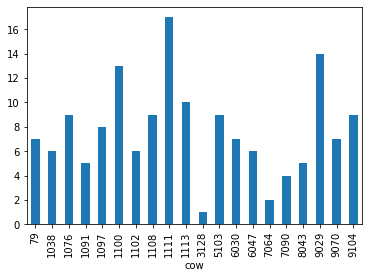

In [100]:
# how do events vary by animal?
final2.groupby('cow')['replace'].sum().plot(x='cow', y='replace', kind = 'bar')

Finding: replace behaviour varies between animals

In [111]:
# split into train set of first 2 days and test set of last 2 days
train = final2[final2['date'] < '2013-09-14']
test = final2[final2['date'] >= '2013-09-14']

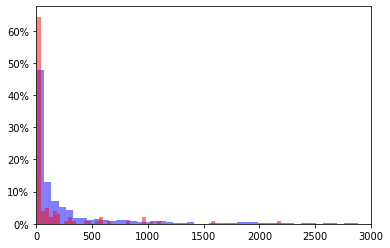

In [156]:
# histogram of replace events in training data
from matplotlib.ticker import PercentFormatter

replace = train[train['replace'] == 1]
nonreplace = train[train['replace'] == 0]

plt.hist(nonreplace['intervalR'], weights=np.ones(len(nonreplace)) / len(nonreplace), color='b',bins = 100, alpha = 0.5, label='Nonreplace')
plt.hist(replace['intervalR'], weights=np.ones(len(replace)) / len(replace), color='r', bins = 100,alpha = 0.5, label='Replace')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlim(0,3000) # narrow in here to make it more interpretable
plt.show()

Finding: postive replace events have shorter intervalR's

In [159]:
# descriptive statistics of positive and negative replace event for intervalR
final2.groupby('replace')['intervalR'].describe()

,count,mean,std,min,25%,50%,75%,max
replace,,,,,,,,
0,1260.0,316.073810,664.244118,9.0,26.0,70.0,279.25,7336.0
1,154.0,258.876623,671.697599,9.0,20.0,32.0,178.50,5675.0


# Logistic Regression and ROC Curve Analysis